In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

In [ ]:
import pandas as pd

Read training file

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/heartbeat_dataset/mitbih_train.csv',header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


total samples for each class

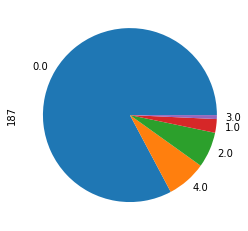

In [ ]:
df_train[187].value_counts().plot.pie()

read testing file

In [ ]:
df_test=pd.read_csv('/content/drive/My Drive/heartbeat_dataset/mitbih_test.csv', header=None)
df_test[187].value_counts()

0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64

In [ ]:
df_1=df_train[df_train[187]==1].reset_index()
df_1.loc[0,:]

index    72471.000000
0            1.000000
1            0.666667
2            0.100457
3            0.036530
             ...     
183          0.000000
184          0.000000
185          0.000000
186          0.000000
187          1.000000
Name: 0, Length: 189, dtype: float64

resample training data

In [ ]:
from sklearn.utils import resample
df_1=df_train[df_train[187]==1]
df_2=df_train[df_train[187]==2]
df_3=df_train[df_train[187]==3]
df_4=df_train[df_train[187]==4]
df_0=df_train[df_train[187]==0].sample(n=18000,random_state=42, replace=True)

df_1_upsample=resample(df_1,replace=True,n_samples=18000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=18000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=18000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=18000,random_state=126)

train_df_resample=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])


number of samples for each class after resample

In [ ]:
train_df_resample[187].value_counts()

1.0    18000
3.0    18000
4.0    18000
2.0    18000
0.0    18000
Name: 187, dtype: int64

take a sample from each class for plotting

In [ ]:
four_rows = train_df_resample.groupby(187).first().reset_index()
four_rows.drop(187, axis=1, inplace=True)
#four_rows

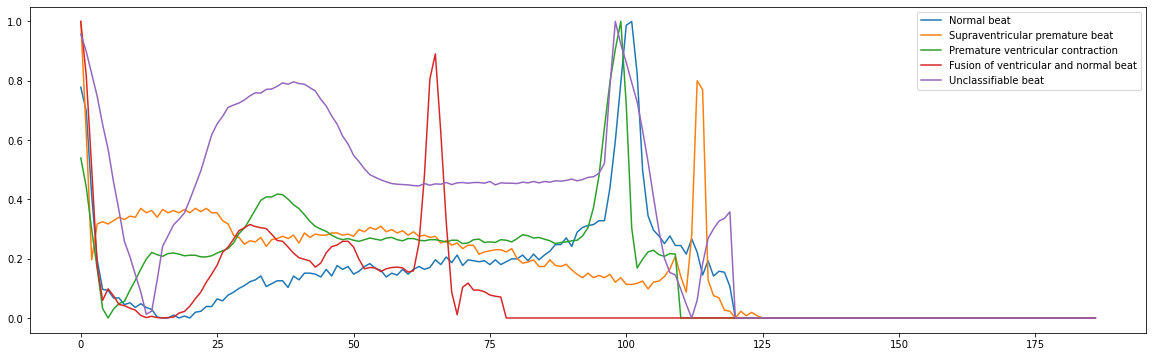

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 187)

plt.figure(figsize=(20,6))
plt.plot(x, four_rows.iloc[0], label="Normal beat")
plt.plot(x, four_rows.iloc[1], label="Supraventricular premature beat")
plt.plot(x, four_rows.iloc[2], label="Premature ventricular contraction")
plt.plot(x, four_rows.iloc[3], label="Fusion of ventricular and normal beat")
plt.plot(x, four_rows.iloc[4], label="Unclassifiable beat")
plt.legend()
plt.show()

split class from features for traing data

In [ ]:
y=train_df_resample[187]
X=train_df_resample.drop(187, axis=1).values


reshape X (features) to fit into the model

In [ ]:
X = X.reshape((len(X),187,1))
X.shape

(90000, 187, 1)

Convert classes to binary class matrix

In [ ]:
from keras.utils import to_categorical

y= y.values.reshape((len(y.values),1))
y = to_categorical(y)
y.shape

(90000, 5)

split and reshape testing data 

In [ ]:
y_test=df_test[187]
X_test=df_test.drop(187, axis=1).values
X_test = X_test.reshape((len(X_test),187,1))
y_test= y_test.values.reshape((len(y_test.values),1))
y_test = to_categorical(y_test)

Model

In [ ]:
from keras.models import Sequential
from keras.optimizers import SGD,Adam
from keras.layers import LSTM, Dense, Flatten, Activation, MaxPool1D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


models = Sequential()
models.add(LSTM(units=128, return_sequences=True, input_shape=(187,1), activation='relu'))
models.add(BatchNormalization())
models.add(MaxPool1D(pool_size=(3), strides=(2), padding="same"))
models.add(LSTM(units=64, return_sequences=True, input_shape=(187,1), activation='relu'))
models.add(BatchNormalization())
models.add(MaxPool1D(pool_size=(2), strides=(2), padding="same"))
models.add(Flatten())
models.add(Dense(32, activation='relu'))
models.add(Dense(5, activation='softmax'))


models.compile(loss='categorical_crossentropy',
              optimizer='adam',
               metrics=['acc'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8), ModelCheckpoint(filepath='best_ecg_modelcopy.h5', monitor='val_loss', save_best_only=True)]
history=models.fit(X, y, epochs=10, batch_size=32,callbacks=callbacks, validation_data=(X_test,y_test))


loss progress

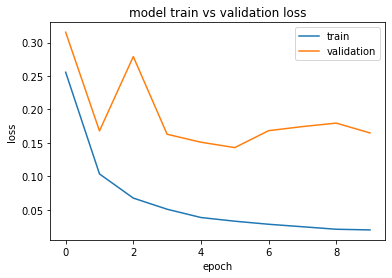

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

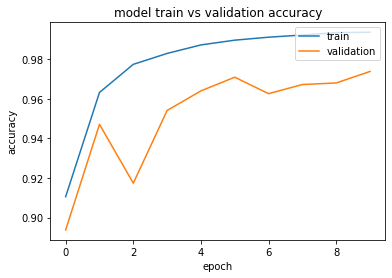

In [ ]:
from matplotlib import pyplot

pyplot.plot([0.9106, 0.9632,0.9774,0.9829, 0.9872, 0.9896, 0.9911, 0.9922, 0.9934, 0.9936])
pyplot.plot([0.8938, 0.9471,0.9174, 0.9541, 0.9640,0.9709,  0.9626,0.9672, 0.9680, 0.9738])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

reload the saved model

In [ ]:
from keras.models import load_model

loaded_model = load_model('/content/drive/My Drive/heartbeat_dataset/best_ecg_modelcopy.h5')
loaded_model.evaluate(X_test,y_test)

685/685 [==============================] - 43s 63ms/step - loss: 0.1430 - acc: 0.9709


[0.14299215376377106, 0.9709026217460632]

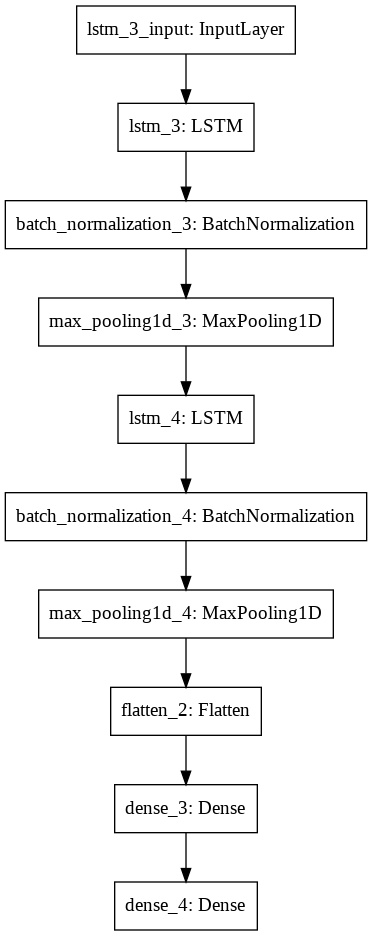

In [ ]:
from keras.utils import plot_model
plot_model(loaded_model, to_file='lstm_model.png')

In [ ]:
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 187, 128)          66560     
_________________________________________________________________
batch_normalization_3 (Batch (None, 187, 128)          512       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 94, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 94, 64)            49408     
_________________________________________________________________
batch_normalization_4 (Batch (None, 94, 64)            256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 47, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3008)             

prediction test

In [ ]:
sample = X[80000].reshape(1,187,1)
pred = loaded_model.predict(sample)
np.argmax(pred,axis=1)

array([4])

In [ ]:
vals = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
inv_vals = {0:'N', 1:'S', 2:'V', 3:'F',  4:'Q'}

In [ ]:
inv_vals[loaded_model.predict(sample).argmax(axis=-1)[0]]

'Q'

Classification report

In [ ]:
predz = loaded_model.predict(X_test).argmax(axis=-1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df_test[187].values,predz) )

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     18118
         1.0       0.61      0.84      0.70       556
         2.0       0.94      0.95      0.94      1448
         3.0       0.61      0.88      0.72       162
         4.0       0.99      0.99      0.99      1608

    accuracy                           0.97     21892
   macro avg       0.83      0.93      0.87     21892
weighted avg       0.98      0.97      0.97     21892



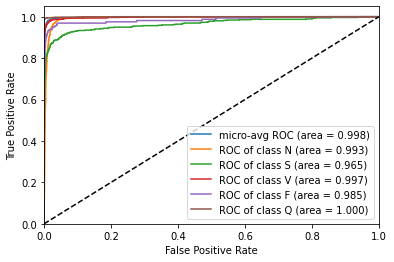

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes=5
proba_pred = loaded_model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
yt = y_test



for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yt[:, i], proba_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yt.ravel(), proba_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-avg ROC (area = {0:0.3f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC of class {0} (area = {1:0.3f})'
                                   ''.format(inv_vals[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('LSTM_roc.pdf', format='pdf')


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df_test[187].values,predz)

array([[17682,   291,    71,    59,    15],
       [   73,   467,     8,     7,     1],
       [   37,    10,  1375,    24,     2],
       [   11,     1,     7,   143,     0],
       [   14,     1,     5,     0,  1588]])